In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy import interpolate
import scipy as sp
import pickle

import xmeos
from xmeos import models
from xmeos import datamod
from xmeos import eoslib

from collections import OrderedDict
CONSTS = models.CONSTS

In [2]:
mgpv_eos = eoslib.MgPv_Mosenfelder2009()

In [18]:
T20 = 2500
T120 = 4500
poly_liq = np.polyfit([20,120], [2500, 4500], 1)

V20 = mgpv_eos.volume(20,T20)
V80 = mgpv_eos.volume(80,T80)
V120 = mgpv_eos.volume(120,T120)

In [17]:
mgpv_eos.thermal_exp(V20,T20)

array([2.83341163e-05])

<IPython.core.display.Javascript object>


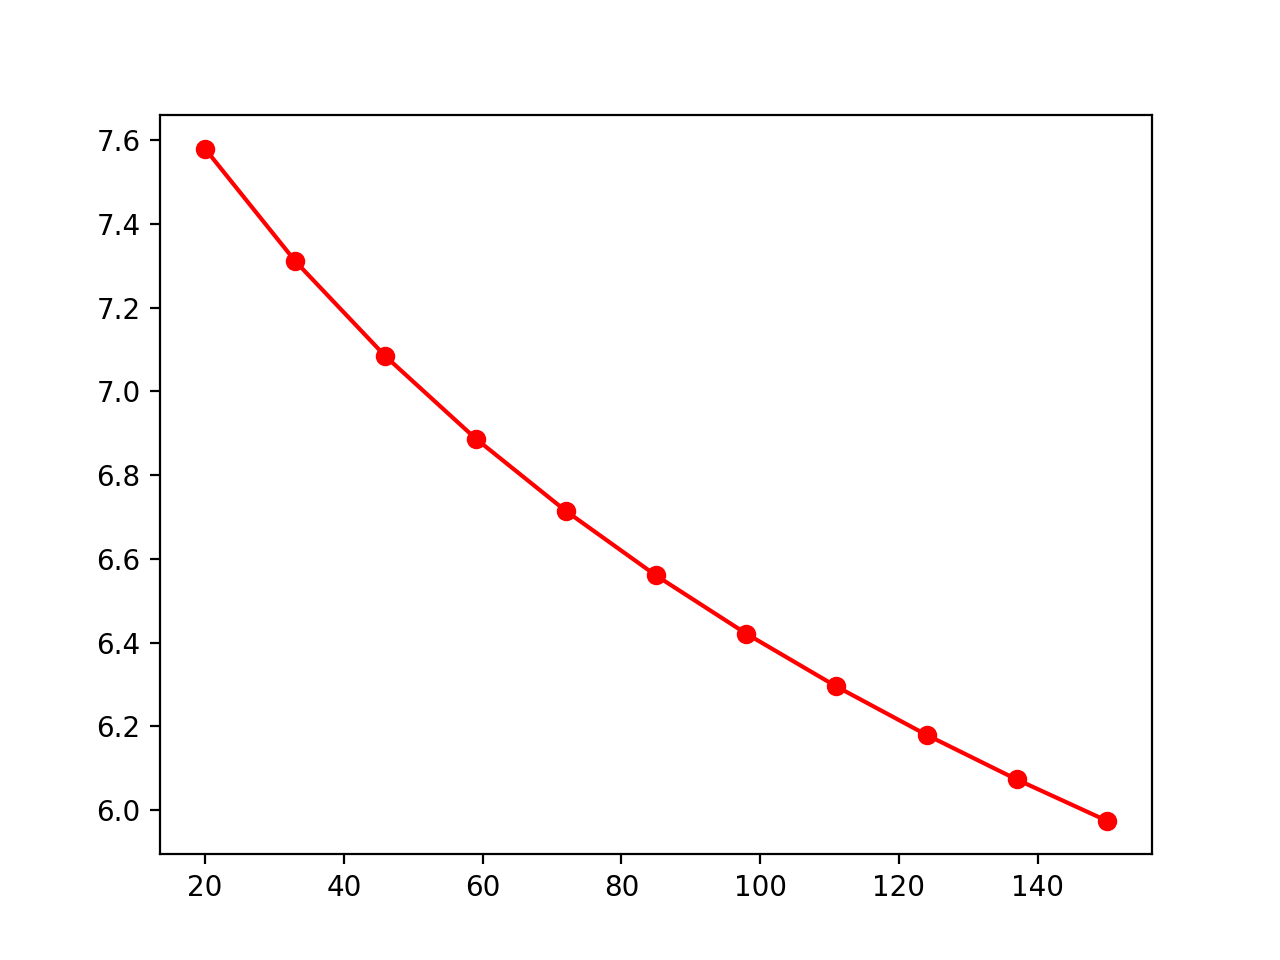

In [49]:
Pmod = np.linspace(20,150, 11)
# Tmod = np.polyval(poly_liq, Pmod)
Tmod = 300*np.ones(Pmod.shape)
Vmod = np.zeros(Pmod.shape)

for ind, (iP, iT) in enumerate(zip(Pmod, Tmod)):
    iV = mgpv_eos.volume(iP, iT)
    Vmod[ind] = iV

plt.figure()
plt.plot(Pmod,Vmod,'r-o')

In [50]:
alpha_mod = mgpv_eos.thermal_exp(Vmod, Tmod)
KT_mod = mgpv_eos.bulk_mod(Vmod, Tmod)

<IPython.core.display.Javascript object>


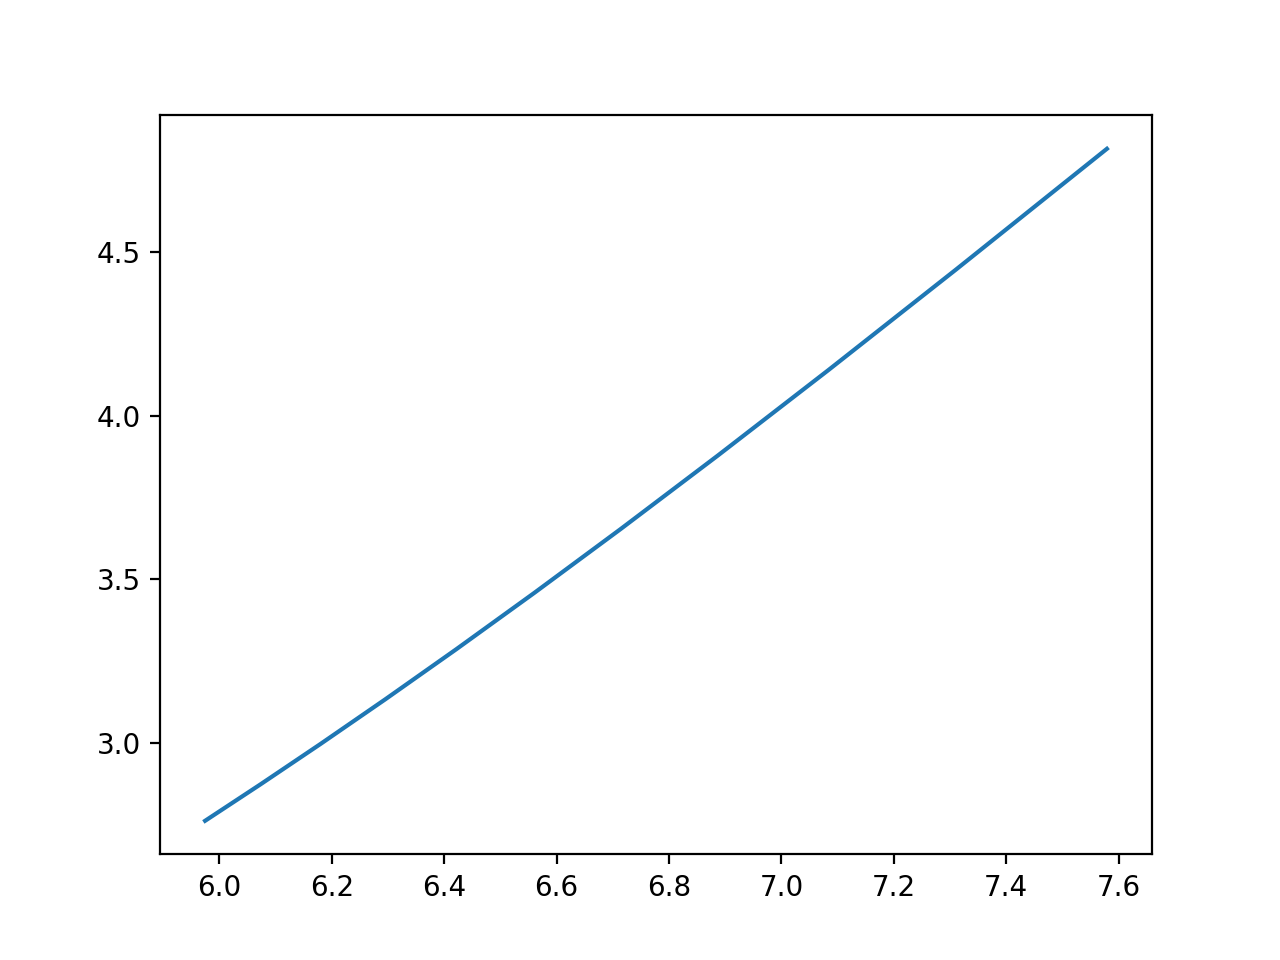

In [52]:
plt.figure()
plt.plot(Vmod, 1e3*alpha_mod*KT_mod, '-')

In [3]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

In [4]:
datamodel = analysis['datamodel']
datamodel_dK09 = analysis['datamodel_dK09']
liq_eos = datamodel['eos_mod']
liq_eos_dK09 = datamodel_dK09['eos_mod']


# data = datamodel['data']
# data_dK09 = datamodel_dK09['data']
# props_Lange = analysis['props_Lange']
# props_Ghiorso = analysis['props_Ghiorso']

liq_eos.apply_electronic = False
liq_eos_dK09.apply_electronic = False


In [32]:
def volume(P, T, eos_mod, Vinit=None, TOL=1e-3, bounds_error=True):


    def press_diff(V, P=P, T=T):
        return eos_mod.press(V, T) - P

    def press_diff_sqr(V, P=P, T=T):
        return (eos_mod.press(V, T) - P)**2

    def press_deriv(V, P=P, T=T):
        K = eos_mod.bulk_mod(V, T)
        dPdV = -K/V
        return dPdV

    
    if Vinit is None:
        V0, = eos_mod.get_param_values(param_names='V0')
        V_min0 = 0.8*V0
    else:
        V_min0 = Vinit
        
    V_min = sp.optimize.fmin(press_diff, V_min0, disp=False)

    #assert np.isscalar(Vinit), 'Vinit must be a scalar val.'
    # V = sp.optimize.fsolve(press_diff, Vinit, fprime=press_deriv)
    
    #V_min = sp.optimize.fmin(press_diff, Vinit, disp=False)

    if +press_diff(V_min) > +TOL:
        if bounds_error:
            raise ValueError(
                'The EOS is being sampled at an unphysical '
                'location! The target pressure is not accesible '
                'at this temperature.'
            )
        V = np.nan

    elif Vinit is None:
        output = sp.optimize.minimize(
            press_diff_sqr, [0.8*V_min], bounds=[(None, V_min)],
            options={'disp':False})
        V, = output.x

    else:
        #output = sp.optimize.minimize(
        #    press_diff_sqr, [Vinit], bounds=[(None, V_min)],
        #    options={'disp':False})
        #V, = output.x
        V = sp.optimize.fsolve(press_diff, Vinit, fprime=press_deriv)
    return V


## Adjust liquid entropy to be realistic at reference point on melting curve

In [42]:
def adjust_melting_entropy(P_fus0, T_fus0, sol_eos, liq_eos, dS_fus=1.5, Vliq_init=9.1):
    Vliq_fus0 = volume(P_fus0, T_fus0, liq_eos, Vinit=9)
    Vsol_fus0 = volume(P_fus0, T_fus0, sol_eos)
    
    # print(Vliq_fus0)
    # print(Vsol_fus0)

    # print(liq_eos.press(Vliq_fus0, T_fus0))
    # print(sol_eos.press(Vsol_fus0, T_fus0))

    liq_eos.set_param_values(0, param_names='S0')

    Sliq_fus0_init = liq_eos.entropy(Vliq_fus0, T_fus0)
    Ssol_fus0 = sol_eos.entropy(Vsol_fus0, T_fus0)

    S0 = Ssol_fus0 + dS_fus*CONSTS['kboltz'] - Sliq_fus0_init
    liq_eos.set_param_values(S0, param_names='S0')
    
    TOL = 1e-5
    S_error = (liq_eos.entropy(Vliq_fus0, T_fus0)
               - sol_eos.entropy(Vsol_fus0, T_fus0))/CONSTS['kboltz']-dS_fus
    assert np.abs(S_error)<TOL, (
        'fusion entropy does not match expectation... something wrong here.'
    )
    pass

In [34]:
liq_eos_dK09.press(9.1,2900)

array([24.67392532])

In [43]:
P_fus0 = 25
T_fus0 = 2900

adjust_melting_entropy(P_fus0, T_fus0, mgpv_eos, liq_eos, dS_fus=1.5)
adjust_melting_entropy(P_fus0, T_fus0, mgpv_eos, liq_eos_dK09, dS_fus=1.5)

In [47]:
liq_eos.get_param_values(param_names='S0')

array([0.00056151])

In [48]:
liq_eos_dK09.get_param_values(param_names='S0')

array([0.00058155])

In [49]:
def trace_phase_bound(Pinit, Tinit, Plim, phase1_eos, phase2_eos, 
                      Vinit1=None, Vinit2=None, N=100):
    
    Pbound = np.linspace(Pinit, Plim, N)
    Tbound = np.zeros(N)
    Tbound[0] = Tinit
    
    dP = Pbound[1]-Pbound[0]
    
    Vphase1_init = volume(Pinit, Tinit, phase1_eos, Vinit=Vinit1)
    Vphase2_init = volume(Pinit, Tinit, phase2_eos, Vinit=Vinit2)

    for ind, (P, T) in enumerate(zip(Pbound[:-1], Tbound[:-1])):
        Vphase1 = volume(P, T, phase1_eos, Vinit=Vphase1_init)
        Vphase2 = volume(P, T, phase2_eos, Vinit=Vphase2_init)
        
        dV = Vphase2-Vphase1
        dS = (phase2_eos.entropy(Vphase2, T) 
              - phase1_eos.entropy(Vphase1, T))[0]
        
        dTdP = dV/dS/CONSTS['PV_ratio']
        dT = dTdP*dP
        
        Pbound[ind+1] = P+dP
        Tbound[ind+1] = T+dT
        
        Vphase1_init = Vphase1
        Vphase2_init = Vphase2

    return Pbound, Tbound

In [50]:
P_fus, T_fus =  trace_phase_bound(P_fus0, T_fus0, 136, mgpv_eos, liq_eos)
P_fus_dK09, T_fus_dK09 =  trace_phase_bound(P_fus0, T_fus0, 136, 
                                            mgpv_eos, liq_eos_dK09, Vinit2=9)


<IPython.core.display.Javascript object>


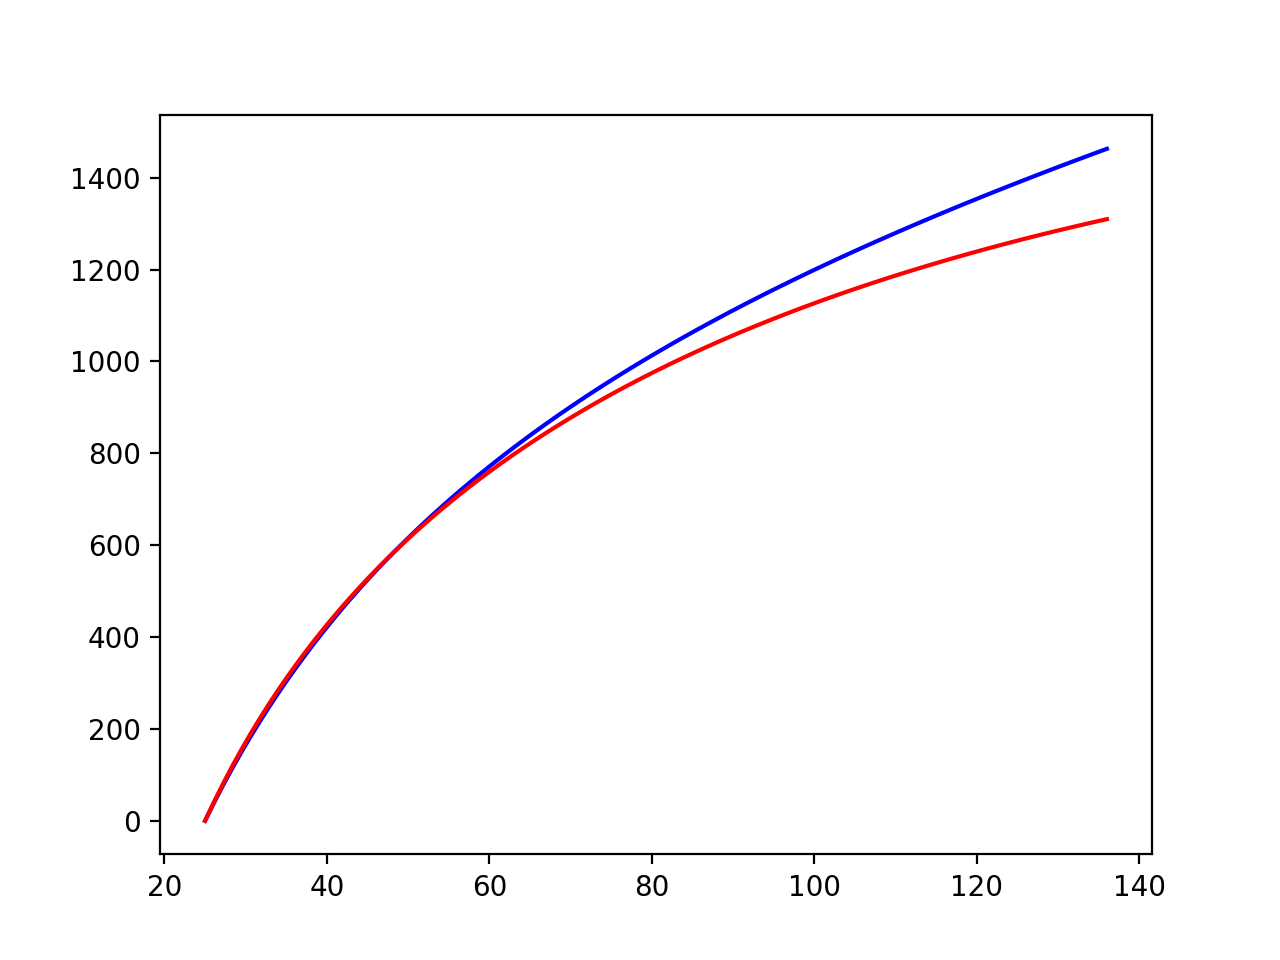

In [59]:
plt.figure()
plt.plot(P_fus, T_fus-2900, 'b-',
        P_fus_dK09, (T_fus_dK09-2900)/1.5, 'r-')

#plt.ylim(2500,5000)

<IPython.core.display.Javascript object>


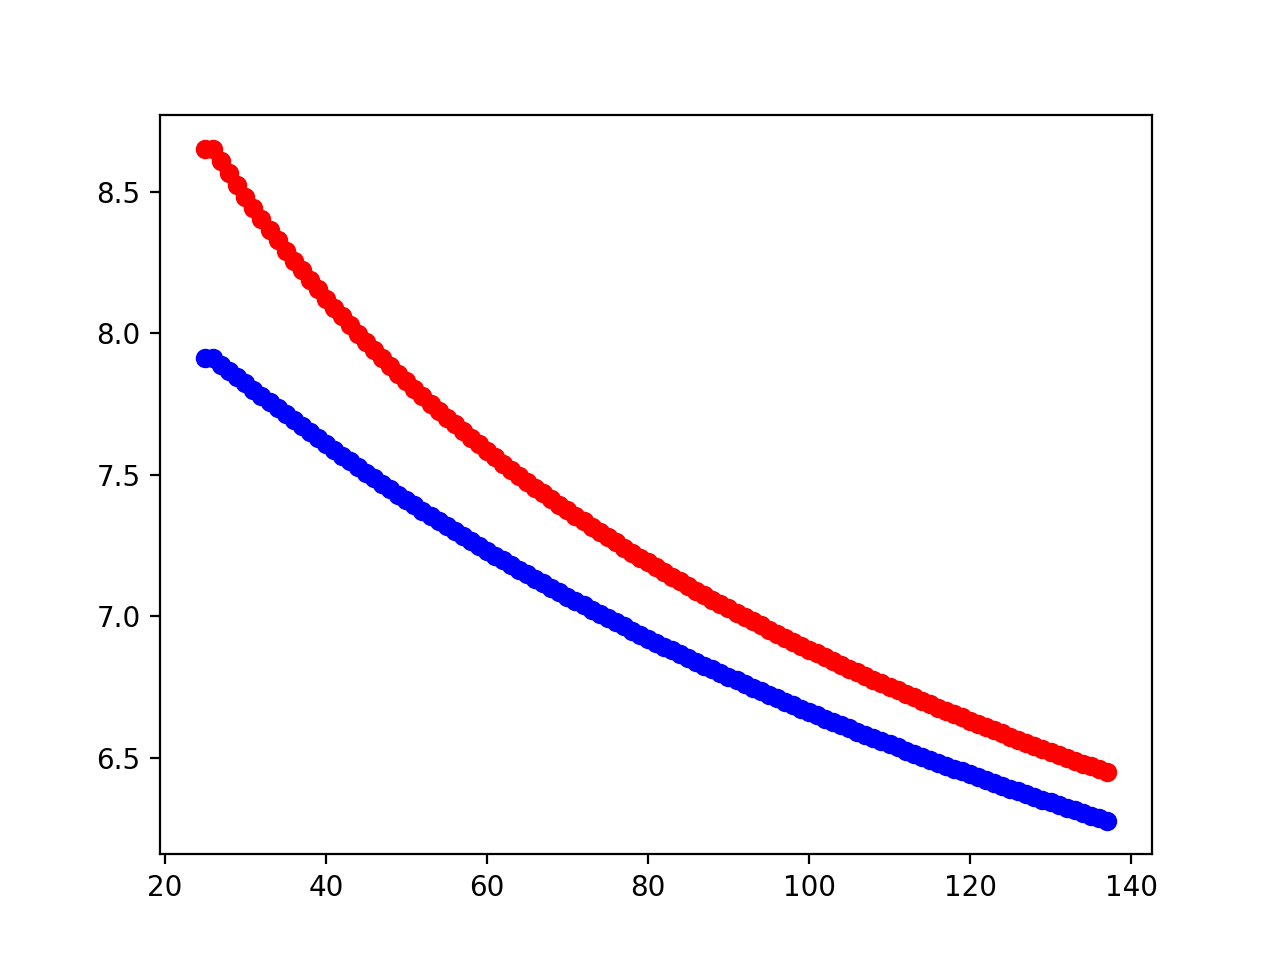

In [95]:
plt.figure()
plt.plot(P_fus, Vfus_sol, 'b-o')

plt.plot(Pfus, Vfus_liq, 'r-o')

<IPython.core.display.Javascript object>


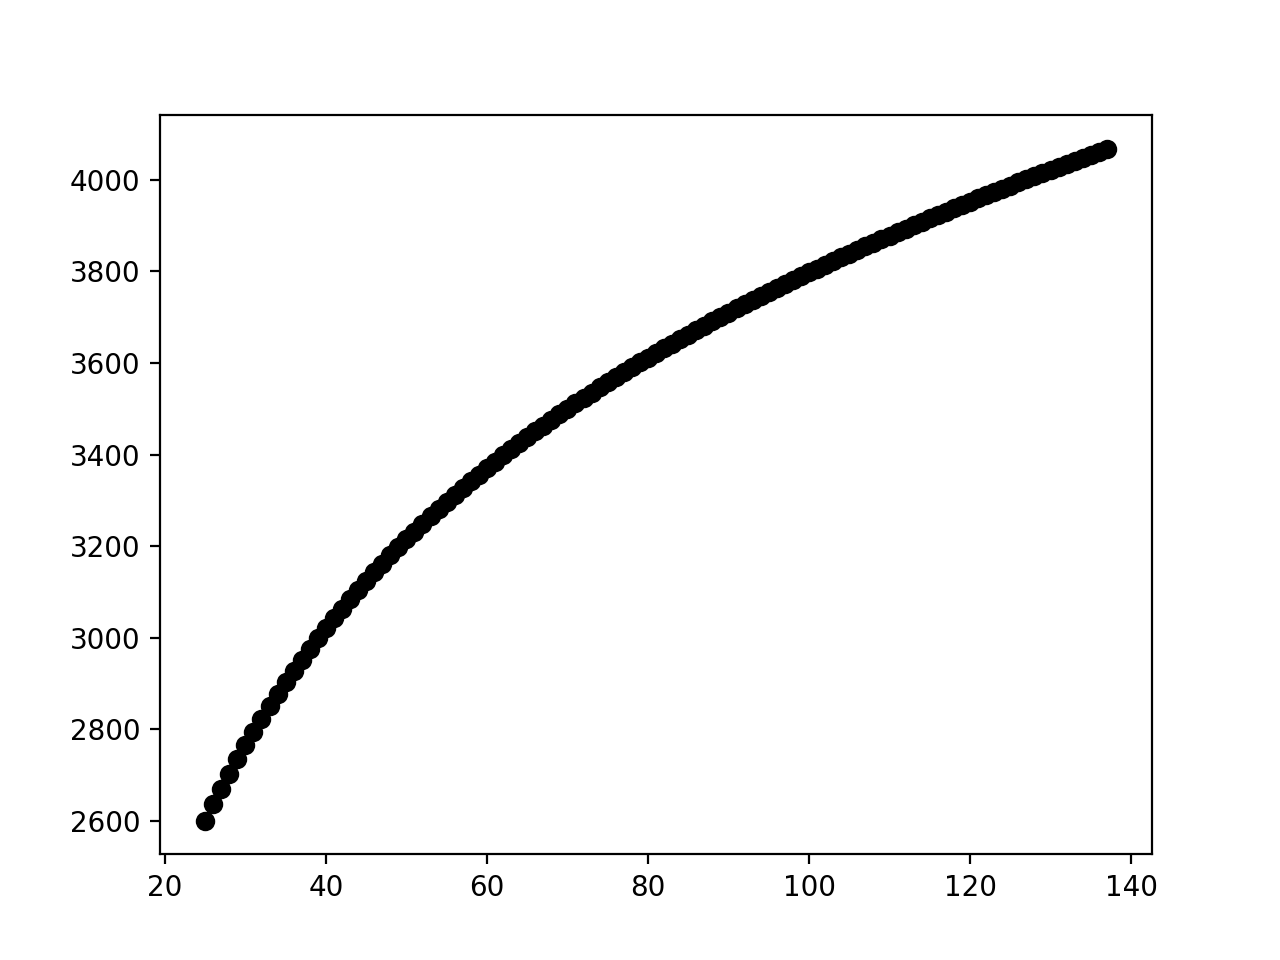

In [97]:

plt.figure()
plt.plot(Pfus, Tfus-300, 'k-o')

In [49]:
CONSTS

{'JperCal': 4.184,
 'JperHa': 4.35974434e-18,
 'Nmol': 6.0221413e+23,
 'PV_ratio': 160.2176487,
 'R': 8.314462,
 'TS_ratio': 96485.33908174829,
 'ang3percc': 1e+24,
 'eVperHa': 27.211,
 'kJ_molpereV': 96.49,
 'kboltz': 8.617332e-05}

In [10]:
Pgrid = np.arange(0,1.01e3,10)
Tfoot_grid = np.arange(1e3,4401,200)
Vad_grid, Tad_grid = eos_mod.adiabatic_path_grid(Tfoot_grid,Pgrid)
props = eos_mod.material_properties(Vad_grid, Tad_grid)

In [11]:

cmap = plt.get_cmap('coolwarm', len(Tfoot_grid))
        
colors = cmap(np.linspace(0,1,len(Tfoot_grid)))

<IPython.core.display.Javascript object>


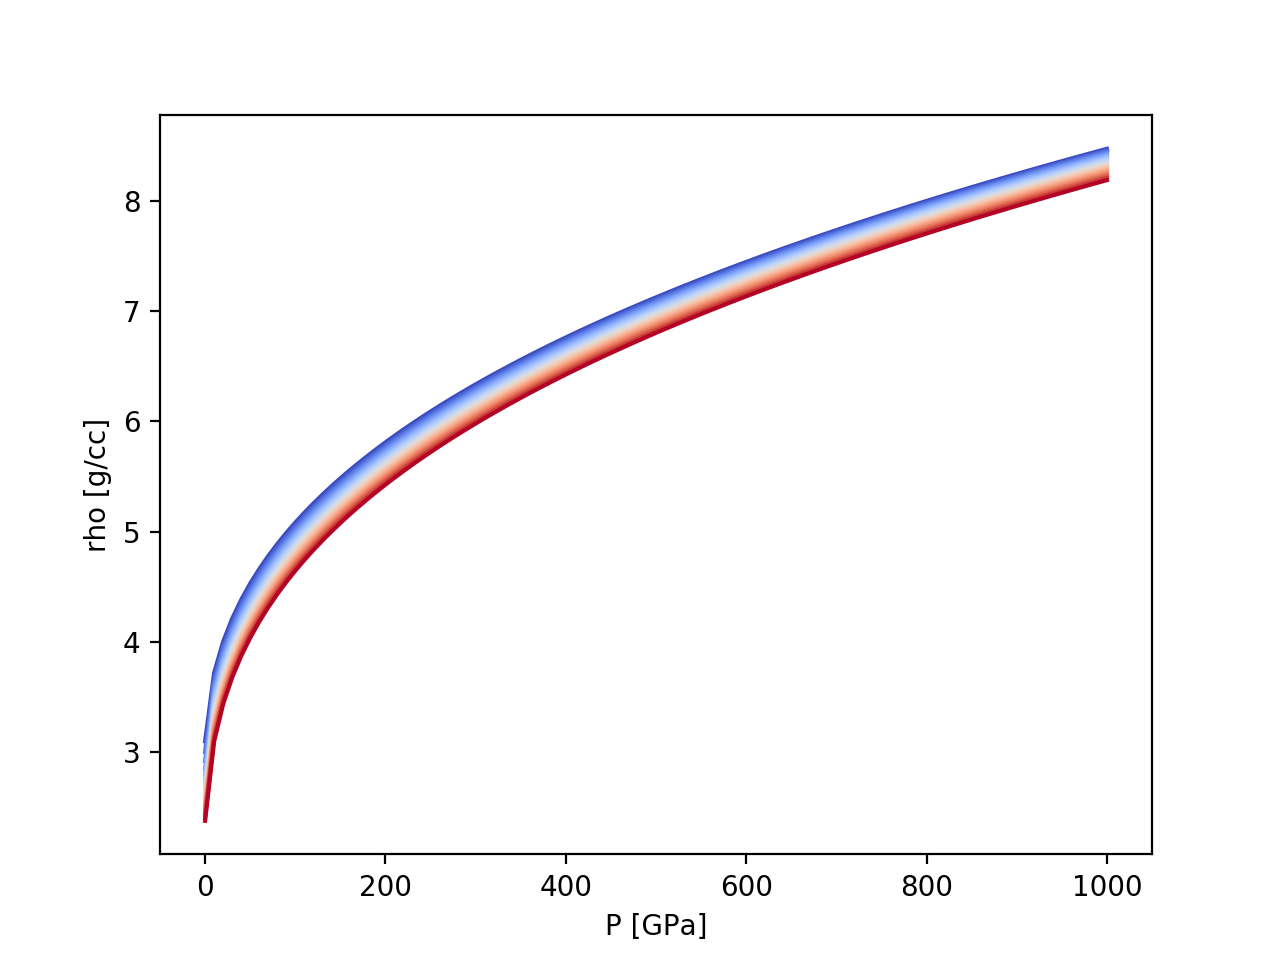

<IPython.core.display.Javascript object>


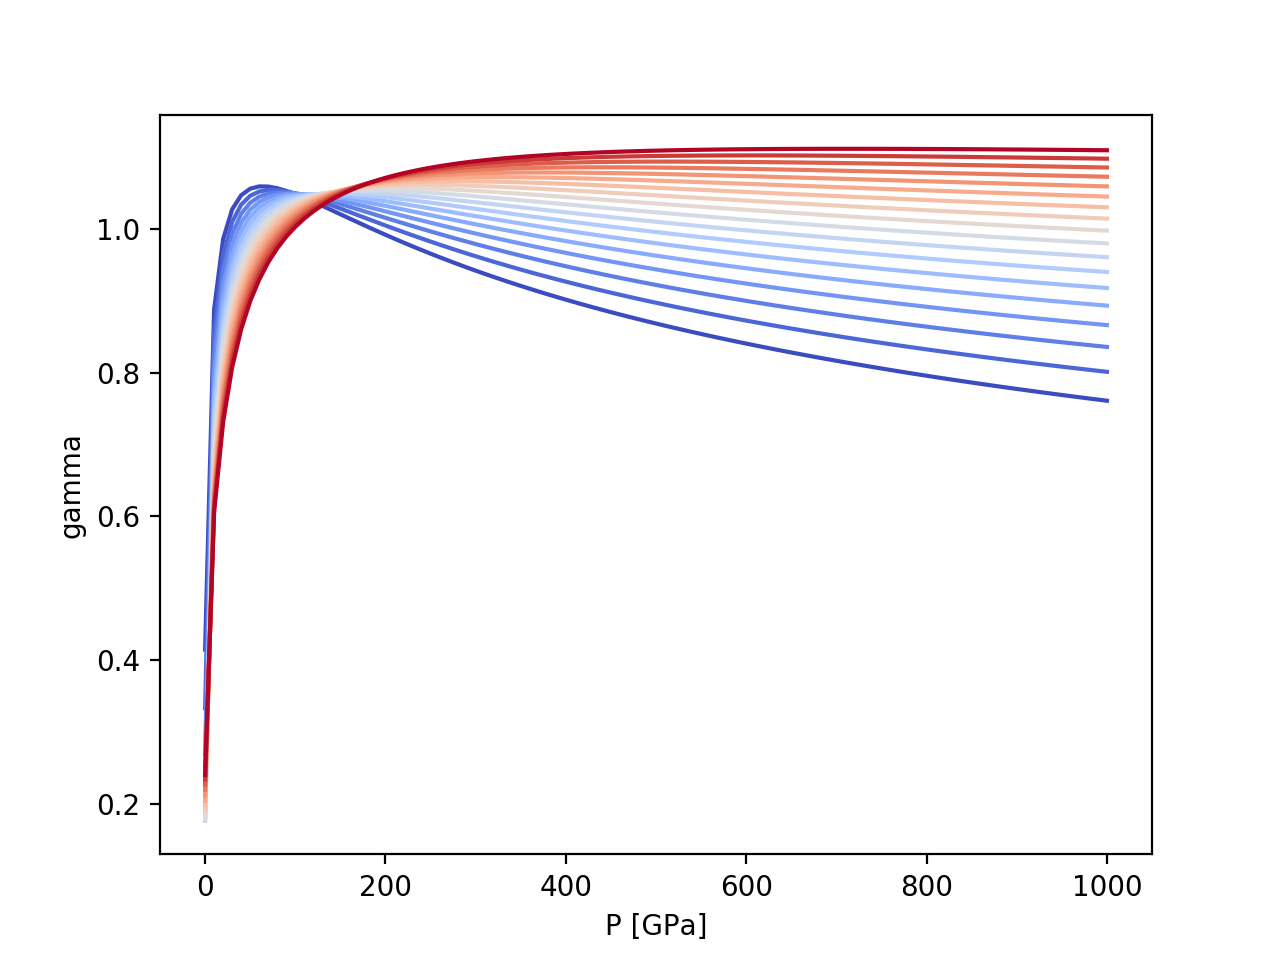

<IPython.core.display.Javascript object>


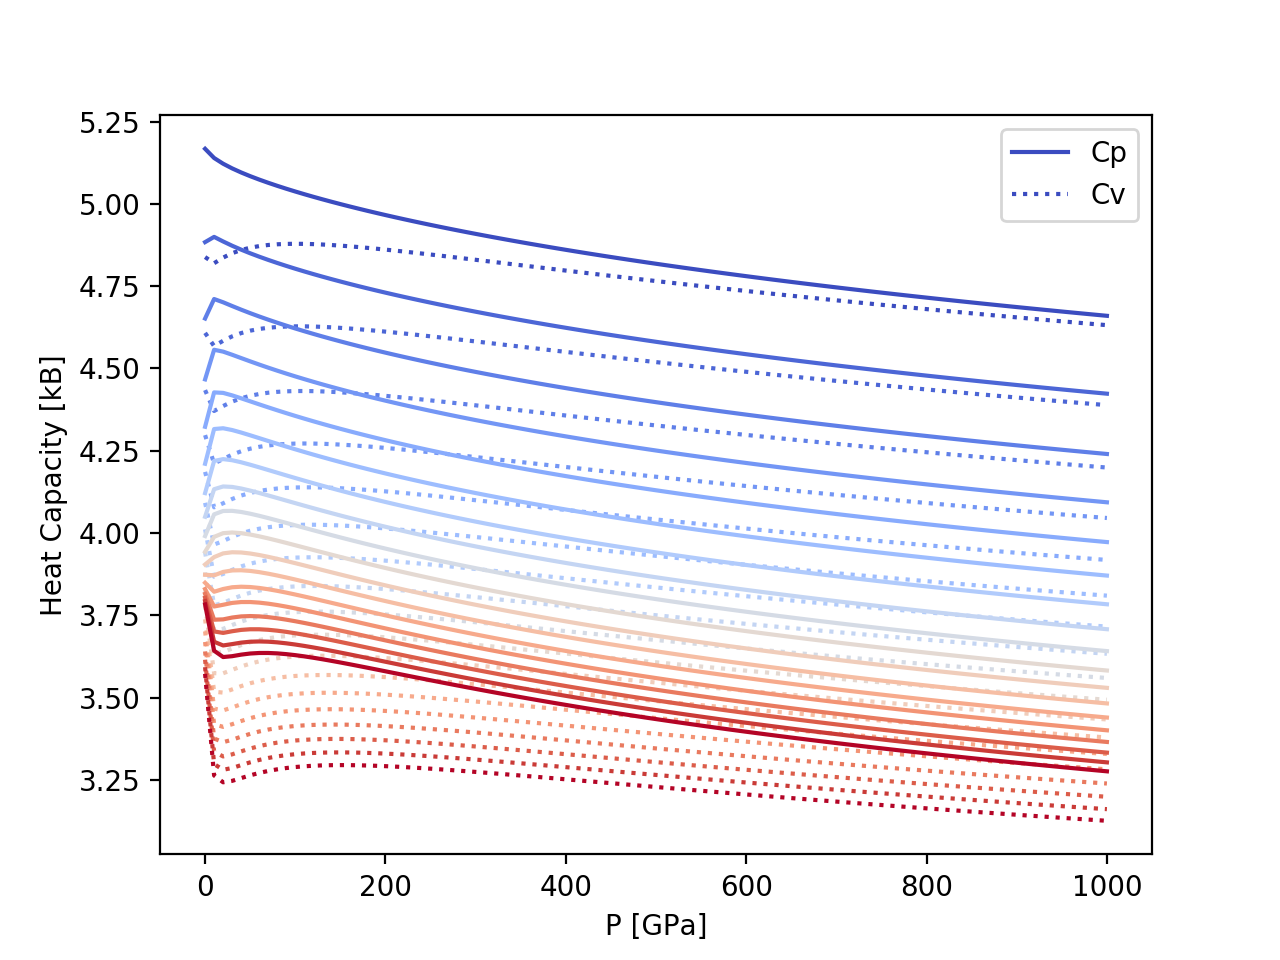

<IPython.core.display.Javascript object>


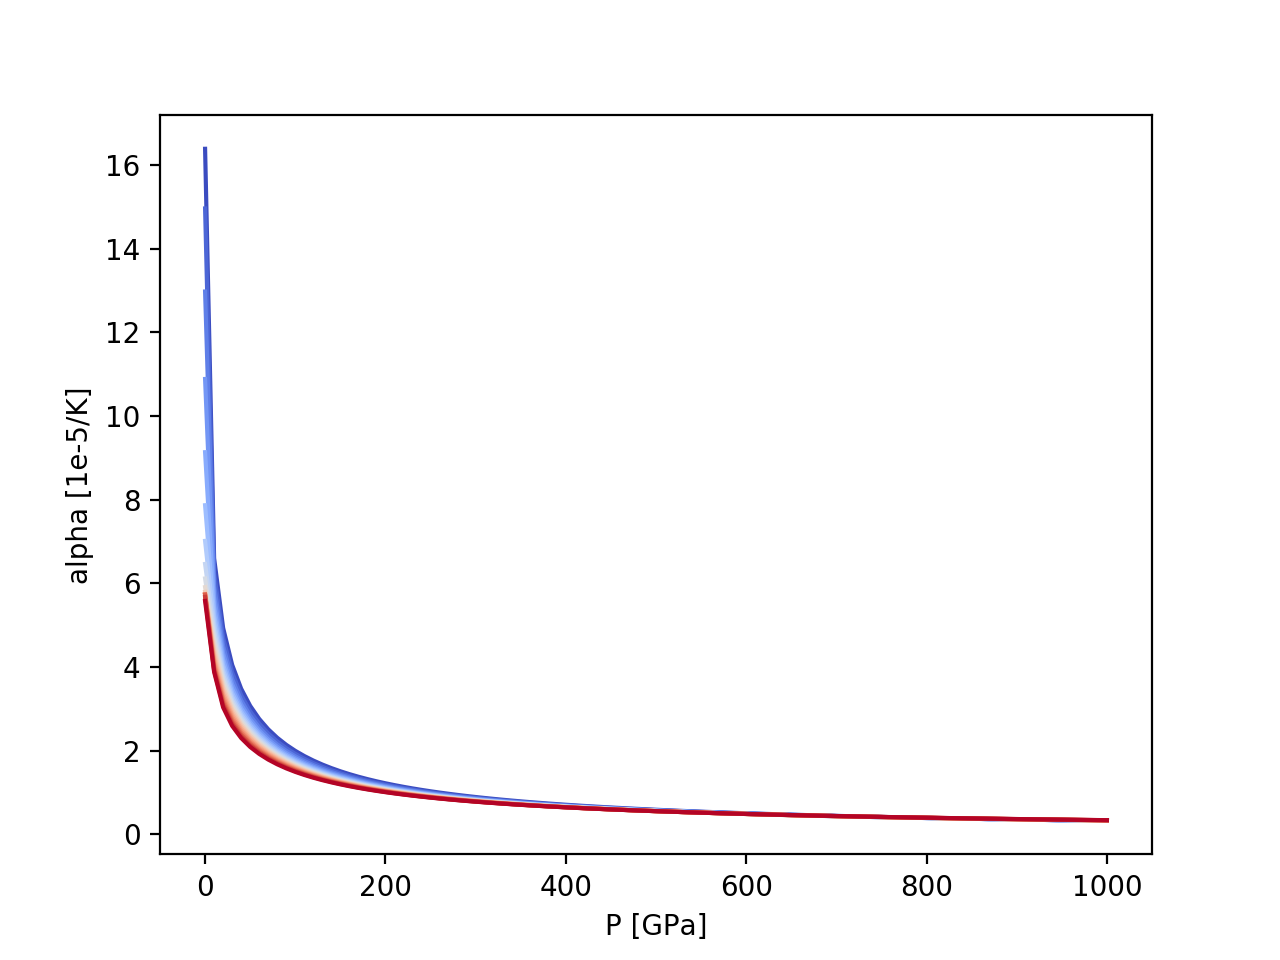

<IPython.core.display.Javascript object>


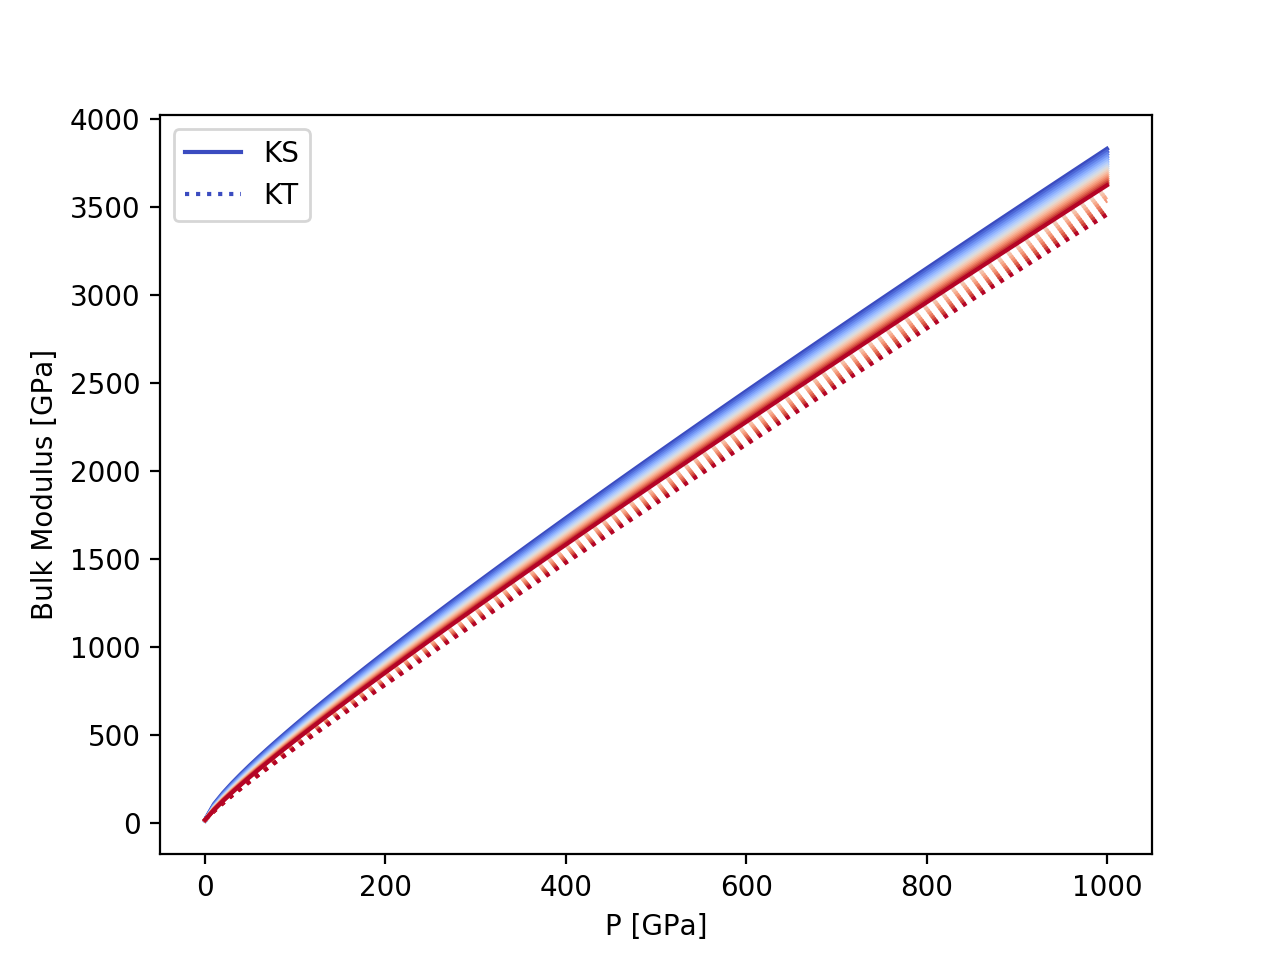

<IPython.core.display.Javascript object>


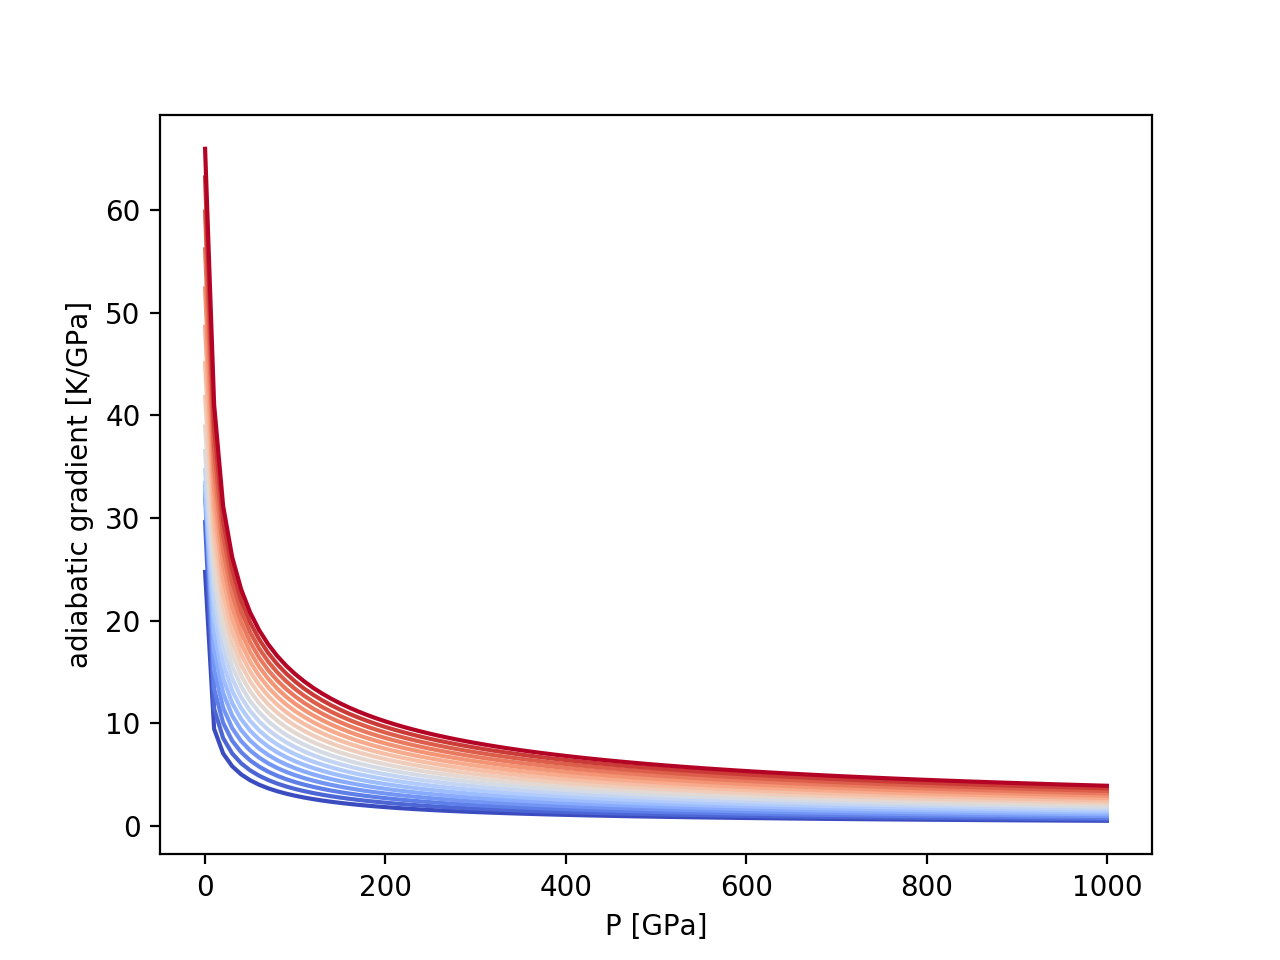

In [12]:
plt.figure()
[plt.plot(iP,irho,color=icol) for iP,irho,icol 
 in zip(props['P'],props['rho'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('rho [g/cc]')

plt.figure()
[plt.plot(iP,igamma,color=icol) for iP,igamma,icol 
 in zip(props['P'],props['gamma'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('gamma')

plt.figure()
lines_Cv = [plt.plot(iP,iCv/models.CONSTS['kboltz'],':', label='Cv', 
                     color=icol)[0] for iP,iCv,icol in 
            zip(props['P'], props['C_V'], colors)]
lines_Cp = [plt.plot(iP,iCp/models.CONSTS['kboltz'],'-', label='Cp', 
                     color=icol)[0] for iP,iCp,icol in 
            zip(props['P'], props['C_P'], colors)]

plt.xlabel('P [GPa]')
plt.ylabel('Heat Capacity [kB]')
plt.legend([lines_Cp[0],lines_Cv[0]], ['Cp','Cv'])

plt.figure()
[plt.plot(iP,ialpha*1e5,color=icol) 
 for iP,ialpha,icol in zip(props['P'], props['alpha'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('alpha [1e-5/K]')


plt.figure()
lines_KT = [plt.plot(iP,iKT,':', color=icol)[0]
 for iP,iKT,icol in zip(props['P'], props['K_T'], colors)]
lines_KS = [plt.plot(iP,iKS,'-', color=icol)[0]
 for iP,iKS,icol in zip(props['P'], props['K_S'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('Bulk Modulus [GPa]')
plt.legend([lines_KS[0],lines_KT[0]], ['KS','KT'])

plt.figure()
[plt.plot(iP,idTdPs,color=icol) 
 for iP,idTdPs,icol in zip(props['P'], props['dTdP_S'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('adiabatic gradient [K/GPa]')


<IPython.core.display.Javascript object>


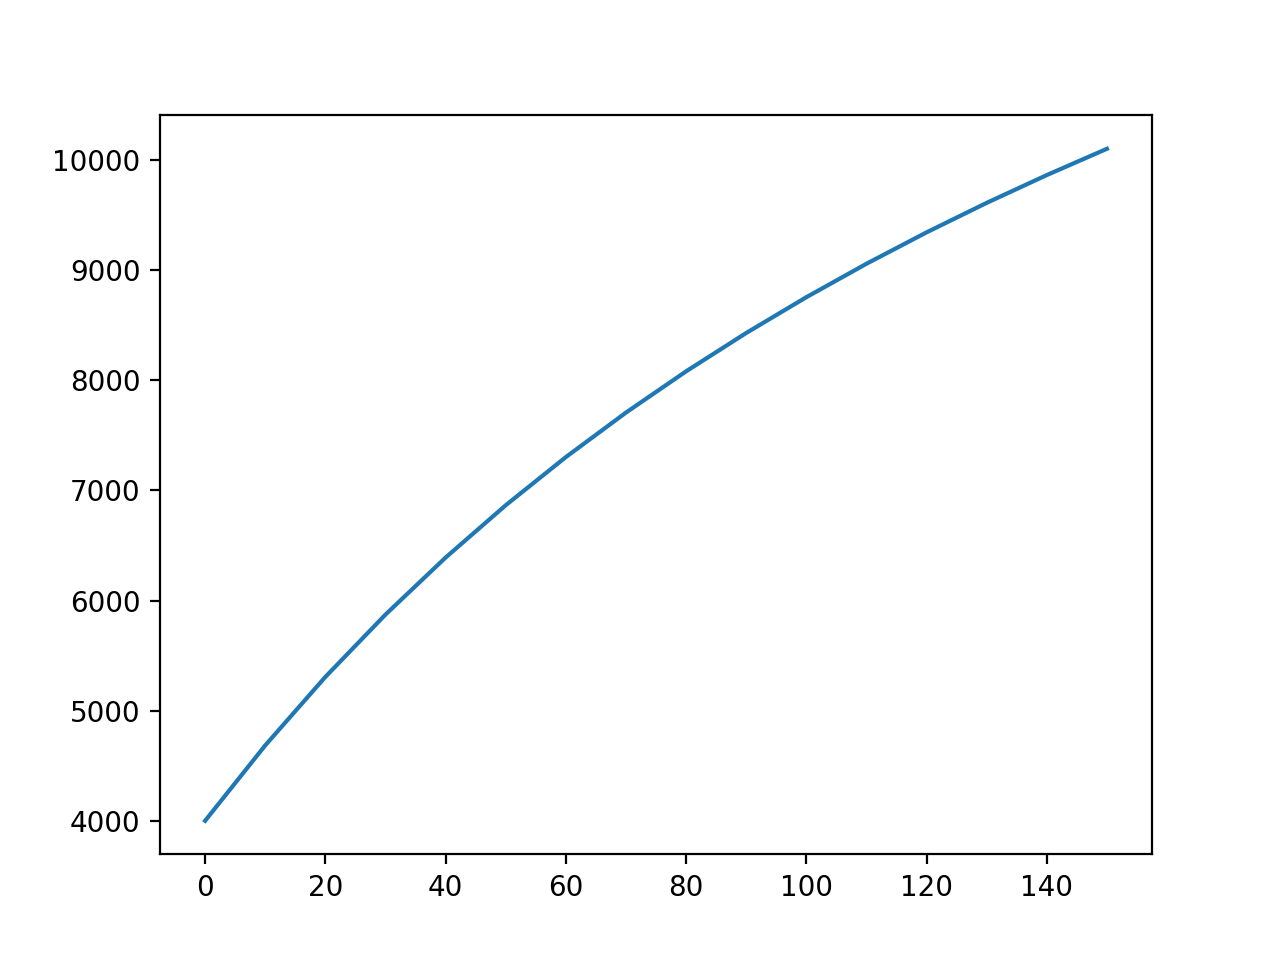

<IPython.core.display.Javascript object>


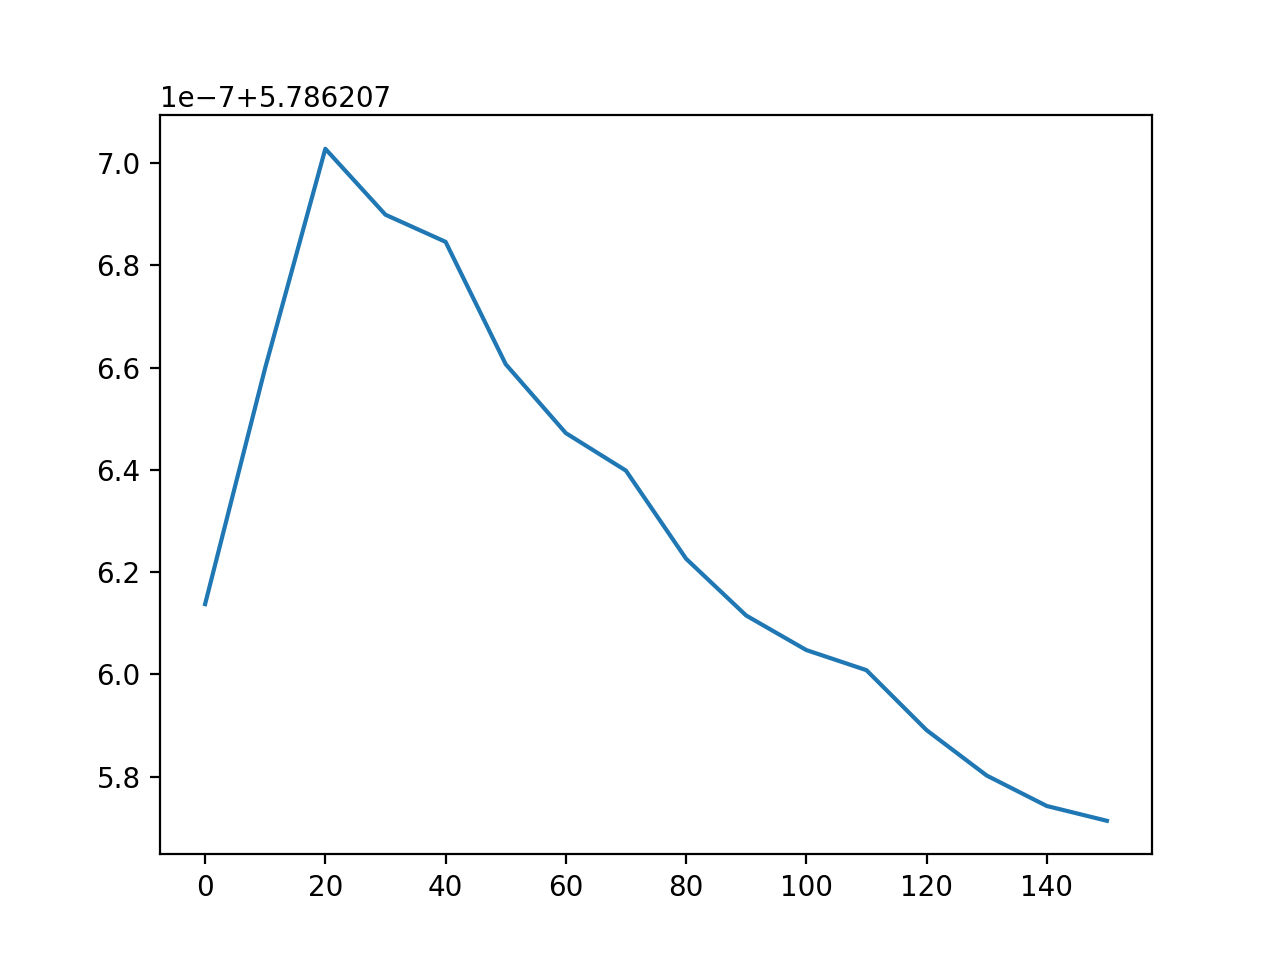

In [6]:
Pgrid = np.arange(0,150.1,10)
Vgrid, Tgrid = eos_mod.adiabatic_path(4000,Pgrid)

Sgrid = eos_mod.entropy(Vgrid, Tgrid)
plt.figure()
plt.plot(Pgrid, Tgrid, '-')

plt.figure()
plt.plot(Pgrid, Sgrid/models.CONSTS['kboltz'], '-')

<IPython.core.display.Javascript object>


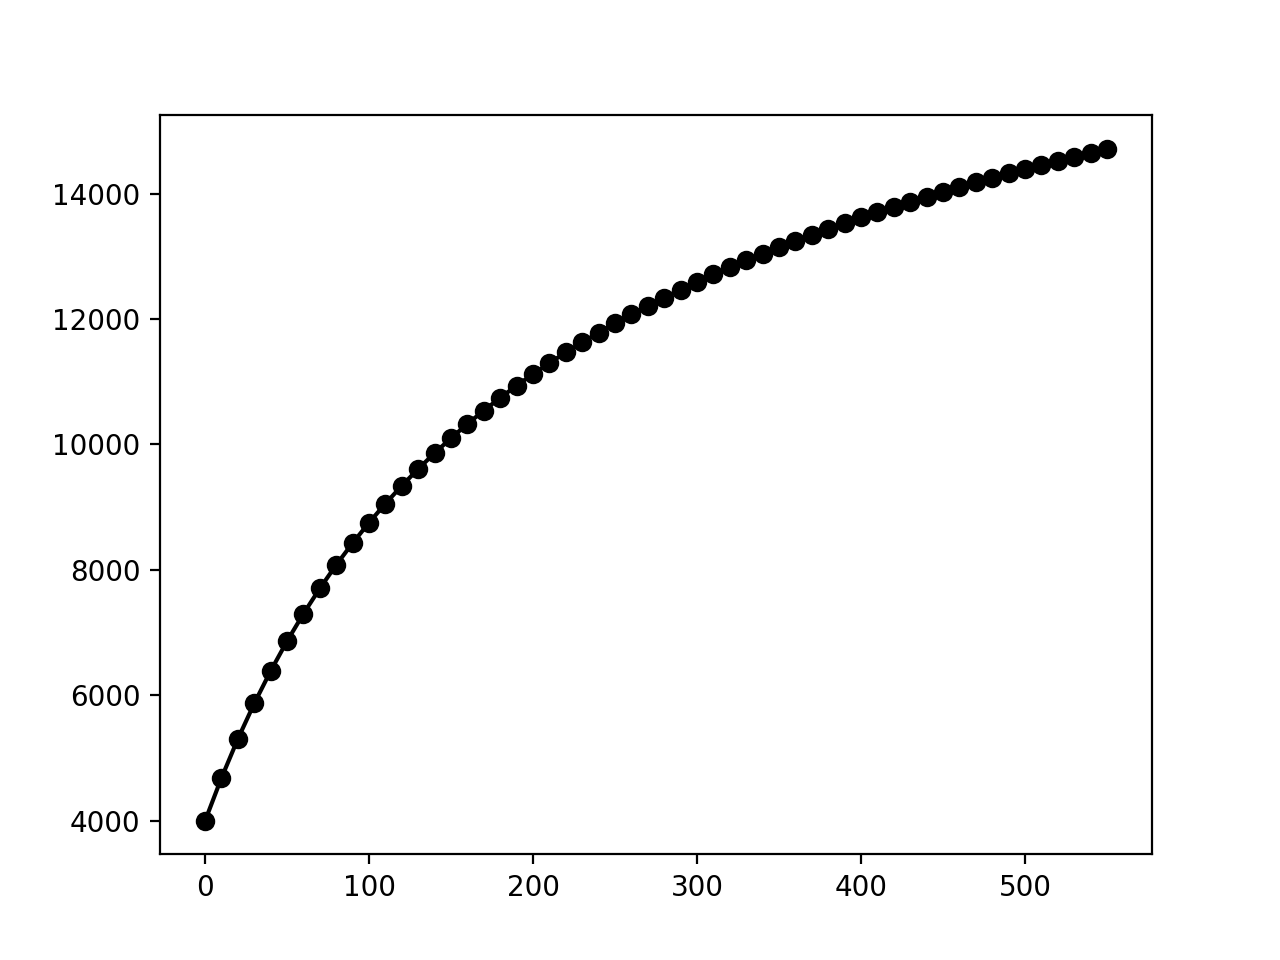

<IPython.core.display.Javascript object>


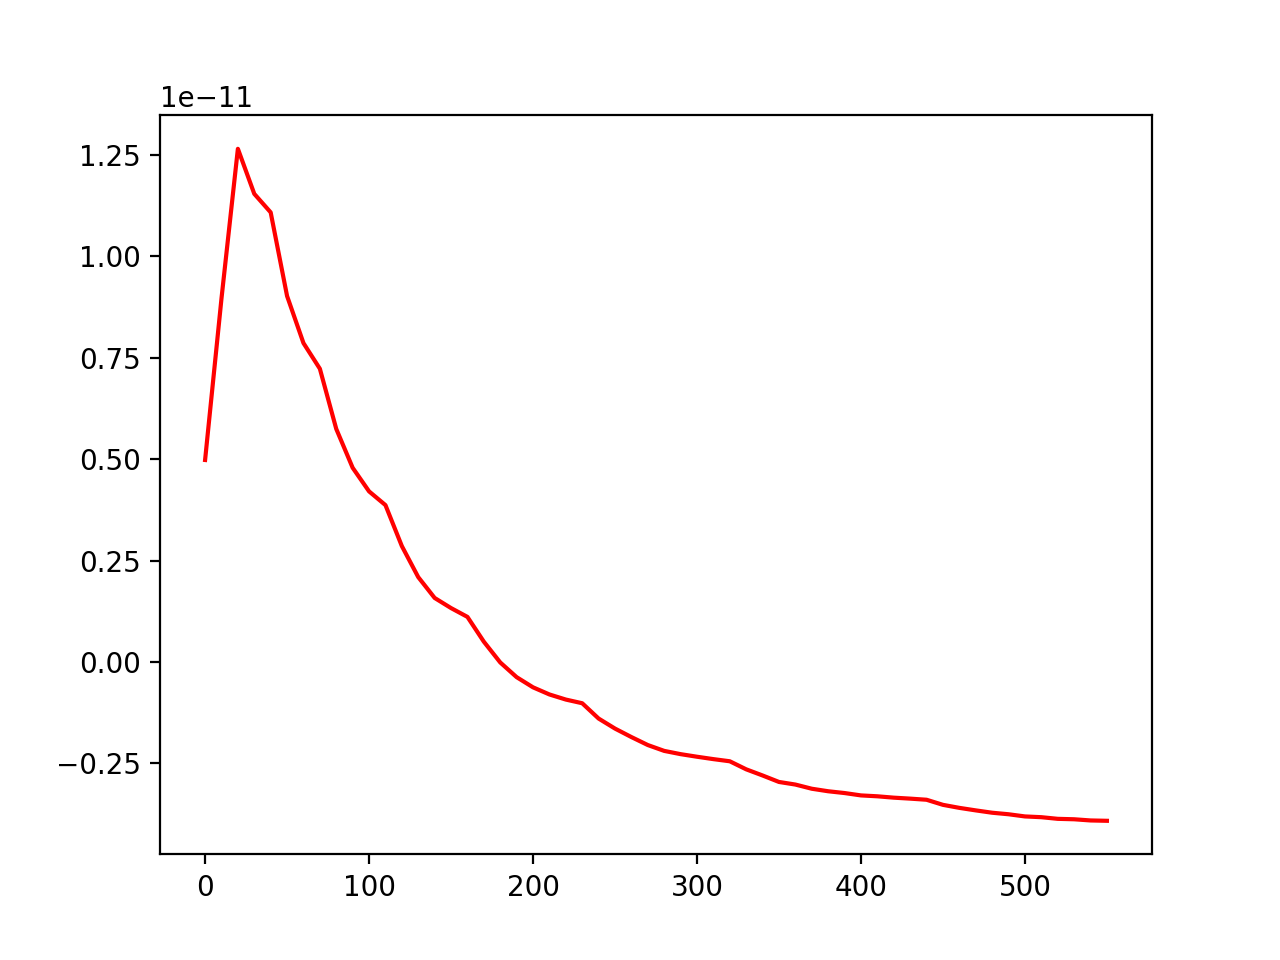

In [10]:
Pgrid = np.arange(0,550.1,10)
Vgrid, Tgrid = eos_mod.adiabatic_path(4000,Pgrid)
Sgrid = eos_mod.entropy(Vgrid, Tgrid)
plt.figure()
plt.plot(Pgrid, Tgrid, 'ko-')

plt.figure()
plt.plot(Pgrid,Sgrid-np.mean(Sgrid),'r-')

In [4]:
eos_mod.apply_electronic = False
Pgrid = np.arange(0,1.01e3,10)
Tfoot_grid = np.arange(1e3,4401,200)

#Tfoot_grid = np.arange(1e3,10.1e3,1000)
Vad_grid, Tad_grid = eos_mod.adiabatic_path_grid(Tfoot_grid,Pgrid)
props = eos_mod.material_properties(Vad_grid, Tad_grid)

/Users/aswolf/Documents/projects/xmeos/xmeos/models/thermal.py:372: RuntimeWarning: invalid value encountered in true_divide
  x = core.fill_array(theta/T_a)
/Users/aswolf/Documents/projects/xmeos/xmeos/models/thermal.py:373: RuntimeWarning: invalid value encountered in true_divide
  xref = core.fill_array(theta0/T0)
/Users/aswolf/Documents/projects/xmeos/xmeos/models/_debye.py:98: RuntimeWarning: divide by zero encountered in log
  S_factor = 4/3*debye3_fun(x_array) - np.log(1-np.exp(-x_array))
/Users/aswolf/Documents/projects/xmeos/xmeos/models/thermal.py:351: RuntimeWarning: invalid value encountered in true_divide
  xref = core.fill_array(theta/T0)
/Users/aswolf/Documents/projects/xmeos/xmeos/models/_debye.py:168: RuntimeWarning: divide by zero encountered in true_divide
  return 3/x_array*(x_array/(np.exp(x_array)-1) - debye3_fun(x_array))
/Users/aswolf/Documents/projects/xmeos/xmeos/models/_debye.py:168: RuntimeWarning: invalid value encountered in true_divide
  return 3/x_array*

In [12]:
props['gamma']

KeyError: 'gamma'

In [10]:
Vad_grid, Tad_grid = eos_mod.adiabatic_path_grid(Tfoot_grid,Pgrid)

Sad_grid = eos_mod.entropy(Vad_grid,Tad_grid)
Pad_grid = eos_mod.press(Vad_grid,Tad_grid)
Cv = eos_mod.heat_capacity(Vad_grid,Tad_grid)
alpha = eos_mod.thermal_exp(Vad_grid,Tad_grid)
gamma = eos_mod.gamma(Vad_grid, Tad_grid)
KT = eos_mod.bulk_mod(Vad_grid, Tad_grid)

Cp = Cv*(1+alpha*gamma*Tad_grid)
KS = KT*(1+alpha*gamma*Tad_grid)
dTdPs = gamma*Tad_grid/KS
rho = eos_mod.molar_mass/Vad_grid*CONSTS['ang3percc']/CONSTS['Nmol']

In [37]:

# Tfoot_grid = np.arange(2000,9001,1000)
# Tlbl = [2000,2250,2500,2750,3000,3250,3500]
Tlbl = [2000,3500]
delT = Tlbl[1]-Tlbl[0]
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]
Tfoot_grid = Tlbl
Pgrid = np.arange(0,550.1,1)
eos_mod.apply_electronic = True
Vad_grid, Tad_grid = eos_mod.adiabatic_path_grid(Tfoot_grid, Pgrid)

# eos_mod_dK09.apply_electronic = True
# Vad_grid_dK09, Tad_grid_dK09 = eos_mod_dK09.adiabatic_path_grid(Tfoot_grid, Pgrid)

In [38]:
Vad_grid.shape

(2, 551)

In [39]:
Tad_grid.shape

(2, 551)

In [40]:
Pgrid.shape

(551,)

In [41]:
rho_grid = eos_mod.molar_mass/Vad_grid*CONSTS['ang3percc']/CONSTS['Nmol']
rho_grid.shape

(2, 551)

In [42]:
Tad_grid.shape

(2, 551)

<IPython.core.display.Javascript object>


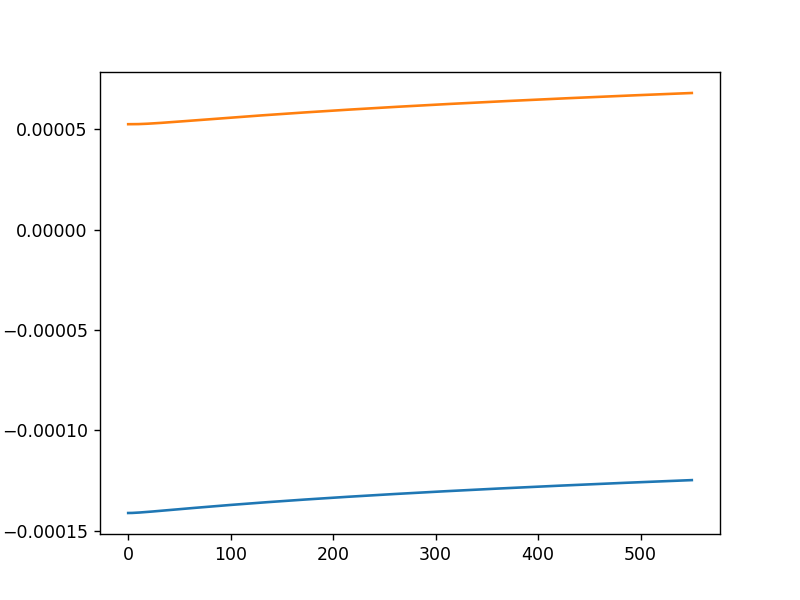

In [45]:
plt.figure()
plt.plot(eos_mod.entropy(Vad_grid.T,Tad_grid.T))

In [54]:
71-58

13

In [13]:
eos_mod.molar_mass/Vad_grid

array([[1.65403767, 1.7577439 , 1.82422216, ..., 4.32130001, 4.32325487,
        4.32520748],
       [1.62405432, 1.72459681, 1.79119986, ..., 4.30688332, 4.30884299,
        4.31080042],
       [1.59773661, 1.69472277, 1.76098718, ..., 4.29280324, 4.29476732,
        4.29672913],
       ...,
       [1.55066879, 1.64141225, 1.70654262, ..., 4.26559046, 4.26756235,
        4.26953195],
       [1.52810236, 1.61646862, 1.68110371, ..., 4.25226981, 4.25424525,
        4.25621839],
       [1.50521655, 1.59170383, 1.65601455, ..., 4.23889425, 4.2408731 ,
        4.24284965]])

In [ ]:
cmap = plt.get_cmap('coolwarm',len(Tlbl))
plot_adiabat_melting_curve(Tlbl, Pgrid, Tad_grid, Tad_grid_dK09, 
              Vad_grid, Vad_grid_dK09)

fig = plt.gcf()


ax_sub = fig.add_axes([.49,.36,.29,.2])
for Vad, Vad_dK09, Tad, Tad_dK09, iTpot in zip(
    Vad_grid, Vad_grid_dK09, Tad_grid, Tad_grid_dK09, Tlbl):
    icol = cmap((iTpot-clims[0])/(clims[1]-clims[0]))
    igamma_ad = eos_mod.gamma(Vad,Tad)
    igamma_ad_dK09 = eos_mod_dK09.gamma(Vad_dK09,Tad_dK09)
    ax_sub.plot(Pgrid,igamma_ad, '-', color=icol,lw=1)
    
ax_sub.set_ylim(0,1.25)
ax_sub.set_xlim(-5,135)
ax_sub.set_xlabel('P [GPa]')
ax_sub.set_ylabel(r'$\gamma$')
# plt.savefig('figs/adiabat-comparison.eps', dpi=450)